## Predicting Fires in the Algerian Forest from Weather Characteristics
### Introduction
A forest fire is an unplanned and an uncontrollable fire which can occur by lightning or human carelessness in forests, shrublands and grasslands. The natural leading causes of forest fires are dry climate, hot temperatures, lightning and volcanic eruption. 
 
There are many factors that contribute to wildfires and thus, we pose a predictive question to determine whether or not duff moisture, drought, fire buildup, fire spread, and fire-weather index cause an increase in the likelihood of forest fires. Furthermore, by looking at these predictors, we hypothesize that an increase in the variables mentioned previously will likely increase the predictability whether or not a fire will be instigated.
 
To support our hypothesis, we are using a dataset on Algerian Forest Fires from UCI. The dataset contains a culmination of forest fires in two regions of Algeria: the Bejaia region and the Sidi Bel-Abbes region. The timeline of this dataset was taken from June 2012 to September 2012. Specifically, we will be focusing on whether certain weather characteristics can predict forest fires in these regions.




In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)
library(GGally)
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

### Reading Data into R:

In [10]:
forest_fire<-read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv', skip=1)%>%
    select(-day, -month, -year)%>%
        filter(Classes!='Classes',
                Temperature!='NA',
                  RH!='NA',
                  Rain!='NA',
                    Ws!='NA',
                   FFMC!="NA",
                   DMC!="NA",
                   DC!="NA",
                   ISI!="NA",
                   BUI!="NA",
                   FWI!="NA") %>%
    mutate(Classes=as_factor(Classes),
        Temperature=as.numeric(Temperature),   
        RH=as.numeric(RH),
        Rain=as.numeric(Rain),
        Ws=as.numeric(Ws),
        FFMC=as.numeric(FFMC),
        DMC=as.numeric(DMC),
        DC=as.numeric(DC),
        ISI=as.numeric(ISI),
        BUI=as.numeric(BUI),
        FWI=as.numeric(FWI)) 

forest_fire_head= head(forest_fire)
forest_fire_head

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_character(),
  Temperature = col_character(),
  RH = col_character(),
  Ws = col_character(),
  Rain = col_character(),
  FFMC = col_character(),
  DMC = col_character(),
  DC = col_character(),
  ISI = col_character(),
  BUI = col_character(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“2 parsing failures.
row col   expected     actual                                                                                                       file
123  -- 14 columns 1 columns  'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
168  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
”


Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire
27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire
31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,fire


 <font color='grey'>Figure 1</font> 

### Preliminary Exploratory Data Analysis: Summarizing Training Data

In [11]:
forest_fire_split<- initial_split(forest_fire, pop= 0.75, strata= Classes)
forest_fire_train<-training(forest_fire_split)
forest_fire_test<-training(forest_fire_split)



forest_fire_train_head=head(forest_fire_train)
forest_fire_train_head

Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire
27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire
31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,fire


 <font color='grey'>Figure 2</font> 

The prop is set to 75% as the orignal dataset is assessed be small (249 entries). By proping to 75%, we will be able to give the training set more samples of the data, which will result in yielding more accurate outcomes for our test dataset.

In [14]:
ff_summary <- forest_fire_train %>%
    select(DMC, DC, ISI, BUI, FWI, Classes) %>%
    group_by(Classes) %>%
    summarize(number_of_instances=n(),
              avg_DMC = mean(DMC),
              avg_DC = mean(DC),
              avg_ISI = mean(ISI),
              avg_BUI = mean(BUI),
              avg_FWI = mean(FWI)
             )
ff_summary

`summarise()` ungrouping output (override with `.groups` argument)



Classes,number_of_instances,avg_DMC,avg_DC,avg_ISI,avg_BUI,avg_FWI
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
not fire,80,6.28000,21.37250,1.201250,7.16500,0.91125
fire,103,20.82524,70.77184,7.308738,23.86796,11.45922


 <font color='grey'>Figure 3</font> 

###  Preliminary Exploratory Data Analysis: Visualizing Training Data 

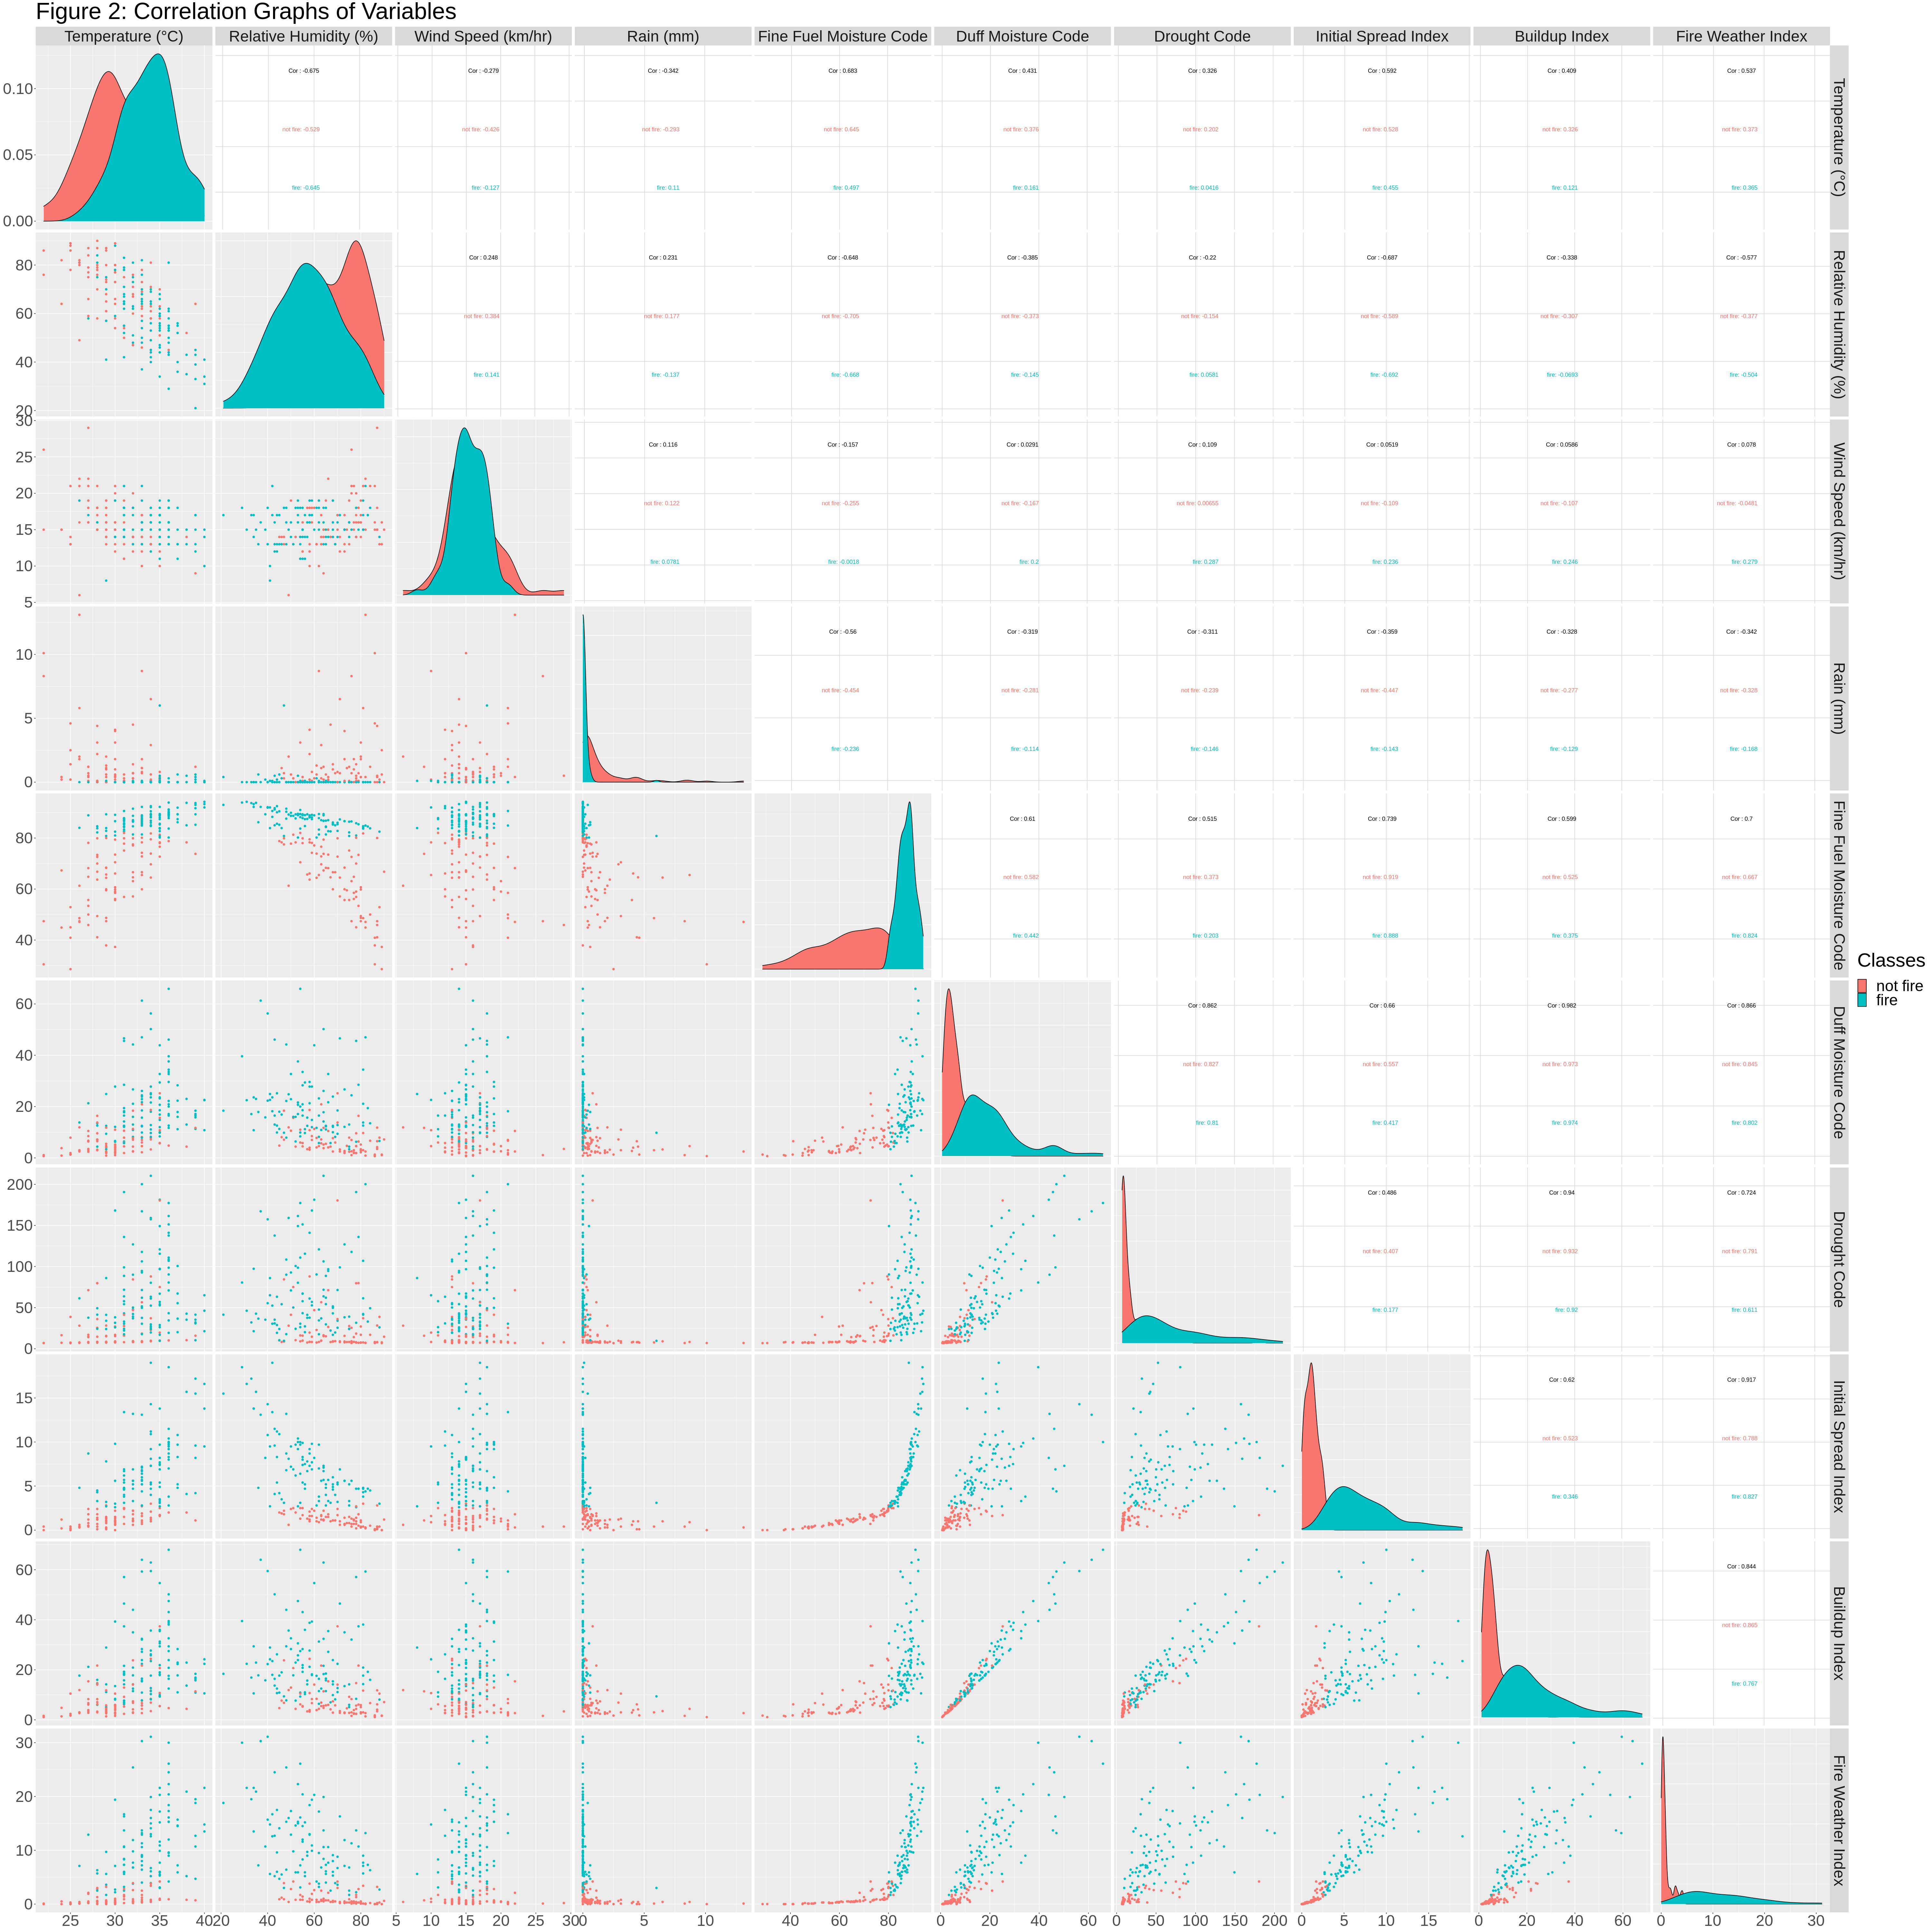

In [15]:
options(repr.plot.width=50, repr.plot.height=50)
forest_fire_graph <- forest_fire_train %>%
    ggpairs(columns =c('Temperature', 'RH','Ws','Rain','FFMC','DMC','DC','ISI','BUI','FWI'),
            columnLabels=c('Temperature (°C)', 'Relative Humidity (%)','Wind Speed (km/hr)', 'Rain (mm)','Fine Fuel Moisture Code','Duff Moisture Code',
                           'Drought Code','Initial Spread Index', 'Buildup Index','Fire Weather Index'),
            legend=1,
           aes(color=Classes))+
    ggtitle("Figure 2: Correlation Graphs of Variables") + 
    theme(text=element_text(size=36))


forest_fire_graph


 <font color='grey'>Figure 4</font> 

### Methods

Based on the graph, the variables with the strong correlation found in our initial exploratory graph will be chosen.  The following varaibles are:
- Duff Moisture Code `DMC`  from 1.1 to 65.9  
- Drought Code `DC`  from 7 to 220.4  
- Initial Spread Index `ISI`  from 0 to 18.5  
- Buildup Index `BUI`  from 1.1 to 68  
- Fire Weather Index `FWI`  from 0 to 31.1


This data analysis will be conducted with the classification method. The chosen variables will determine if an instance of potential fire will be classified as `fire` or `not fire` to determine whether a fire was present.


Our data analysis will be conducted in two main steps: Finding the K value  through fold cross valiadation and then computing the accuracy of our prediction. The 5 fold cross validation will be chosen based on computational capability. Furthermore, the 5 fold validation will be passed in tuning in order to allows us to chose the optimal K to utilize. 

Finally using our K, we will predict our trained data through a classification workflow and then compute the accuracy of the prediction. The results of accuracy will be visualized through the form of a bar graph showing the percentages of correct predictions per predictor. 





### Expected Outcomes and Significance:

We expect to find that the predictors we have indicated will allow us to infer where forest fires may occur in Algeria. These findings could lead to increased knowledge and proactivity in stopping forest fires that may occur in areas with similar predictor values to regions that have experienced forest fires. A future question that may arise from this proposal would be determining which predictor variable would most greatly influence the likelihood of forest fires.



### Data Analysis

In [7]:


knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")
knn_tune

forest_fire_recipe <- recipe(Classes ~ DMC + DC + ISI + BUI + FWI, data = forest_fire_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())
forest_fire_recipe

forest_fire_vfold_5 <- vfold_cv(forest_fire_train, v = 5, strata = Classes)
forest_fire_vfold_10 <- vfold_cv(forest_fire_train, v = 10, strata = Classes)

forest_fire_results_5 <- workflow() %>%
  add_recipe(forest_fire_recipe) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = forest_fire_vfold_5, grid = 10) %>%
  collect_metrics()
forest_fire_results_5
 
accuracies_5 <- forest_fire_results_5 %>%
    filter(.metric == "accuracy") %>%
    filter(mean == max(mean))
accuracies_5 #knn nearest neighbor for highest accuracy with a 5-fold cross-validation

forest_fire_results_10 <- workflow() %>%
  add_recipe(forest_fire_recipe) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = forest_fire_vfold_10, grid = 10) %>%
  collect_metrics()
forest_fire_results_10
 
accuracies_10 <- forest_fire_results_10 %>%
    filter(.metric == "accuracy") %>%
    filter(mean == max(mean)) 
accuracies_10   #knn nearest neighbor for highest accuracy with a 10-fold cross-validation

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Operations:

Scaling for all_predictors()
Centering for all_predictors()

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.9509009,5,0.010076854,Model01
2,roc_auc,binary,0.9732143,5,0.010345313,Model01
3,accuracy,binary,0.9506006,5,0.016276581,Model02
3,roc_auc,binary,0.9782292,5,0.012359829,Model02
5,accuracy,binary,0.9507508,5,0.020314156,Model03
5,roc_auc,binary,0.9873363,5,0.006227834,Model03
6,accuracy,binary,0.9507508,5,0.020314156,Model04
6,roc_auc,binary,0.9873512,5,0.006053823,Model04
7,accuracy,binary,0.9453453,5,0.019540298,Model05


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.9509009,5,0.01007685,Model01


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9453216,10,0.011416830,Model1
1,roc_auc,binary,0.9454545,10,0.011115988,Model1
3,accuracy,binary,0.9558480,10,0.011082433,Model2
3,roc_auc,binary,0.9832386,10,0.007228425,Model2
4,accuracy,binary,0.9558480,10,0.011082433,Model3
4,roc_auc,binary,0.9888068,10,0.006513637,Model3
6,accuracy,binary,0.9669591,10,0.008997004,Model4
6,roc_auc,binary,0.9875568,10,0.007400651,Model4
8,accuracy,binary,0.9614035,10,0.011815503,Model5


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
6,accuracy,binary,0.9669591,10,0.008997004,Model4
10,accuracy,binary,0.9669591,10,0.012228376,Model6


accuracies_5 shows that when C = 5 (i.e. 5-fold cross-validation), the k nearest neighbor with the highest accuracy is k = 2. accuracies_10 show that when C = 10 (i.e. 10-fold cross-validation), the k nearest neighbors with the equally high accuracies are both k = 6 and k = 10. However, k = 6 has a lower standard error than k = 10 and therefore, using a 10-fold cross validation with k = 6 is the best model for our classifier which we will use to predict the classes of fire in our testing data.